# Genz Oscillatory Integrand Family

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import itertools
from sklearn.model_selection import train_test_split
import mlflow

In [3]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [4]:
from solstice.kernels import RBF, RFF, Matern32
from solstice.gp import GP, LowRankGP, fitgp
from solstice.transforms import ARD, FiniteARD
from ffbq.bq import BQ
from ffbq.helpers import grid, regrid, area
from ffbq.eval import metric_gp_bq, generate_data

In [5]:
from ffbq.genz import GenzOscillatory

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


# Define Experiment

In [32]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "oscillatory_dev"

In [33]:
def gaussian_bq(gp, m, X, y, bounds, key, diag=None):
    bq = BQ(gp, m)
    mu, sigma = bq(X, y, bounds=bounds, key=key, diag=diag)
    return mu, sigma

def mc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="mc")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, key=key,
                   diag=diag)
    return mu, sigma

def qmc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="qmc")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, key=key,
                   diag=diag)
    return mu, sigma

def fft_bq(gp, m, X_train, y_train, sr, bounds, diag=None):
    bq = BQ(gp, m, operator="fft")
    mu, sigma = bq(X_train, y_train, bounds=bounds, sr=sr, diag=diag, bounded=True)
    return mu, sigma

def lr_qmc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="lr")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, diag=diag, key=key)
    return mu, sigma

def lr_fft_bq(gp, m, X_train, y_train, sampling_rate, bounds, diag=None):
    bq = BQ(gp, m, operator="lrfft")
    mu, sigma = bq(X_train, y_train, bounds=bounds, sr=sampling_rate, diag=diag, bounded=True)
    return mu, sigma

## Define Run

In [34]:
diag = 1e-4
lr = 0.01
epochs = 200

In [35]:
sols_d = {
    2: (-0.0162558408042687, 0.0), 3: (-0.004755372084347909, 0.0), 
    4: (0.0027555905687096666, 0.0), 5: (-0.0007844448472505237, 0.0), 
    6: (0.00014297458440536777, 0.0)
}

In [201]:
def single_run(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    diag_rbf = 1e-4
    diag_m32 = 1e-4
    diag_fin = 1e-4
    diag_lr = 1e-1
    diag_lr_fft = 1e-1

    if EXPERIMENT is None:
        EXPERIMENT = "oscillatory_dev"

    sol = sols_d[d]
    genz = GenzOscillatory(d)
    ls_init = (genz.bounds[1,:] - genz.bounds[0,:]) / 2

    # make data
    train, val, test = generate_data(genz, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(genz.bounds, sampling_rate=sampling_rate).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(ARD(ls_init, RBF()), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    _, gp_bq, _ = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag)

    ###### RBF GP
    def build_train_rbf_gp(support, X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(FiniteARD(ls_init, RBF(), support), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_rbf_opt = optax.adam(lr)
    print("training rbf gp...")
    _, gp_rbf, _ = build_train_rbf_gp(genz.bounds, X_train, y_train, gp_rbf_opt, epochs, ls_init, diag)

    ###### MATERN 3/2 GP
    def build_train_mat32_gp(d, R, support, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = GP(FiniteARD(ls_init, RFF(key, d, R, base_kernel=Matern32()), support), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_mat32_opt = optax.adam(lr * 10)
    _, gp_mat32, _ = build_train_mat32_gp(d, R, genz.bounds, X_train, y_train, gp_mat32_opt, epochs, ls_init, diag, key=key)

    # ###### RFF GP
    # def build_train_rff(d, R, X, y, opt, epochs, ls_init, diag, key):
    #     gp_pre = GP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    #     # train
    #     gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
    #                     verbose=False, solver="full")
    #     return gp_pre, gp, loss

    # gp_rff_opt = optax.adam(lr * 10)
    # _, gp_rff, _ = build_train_rff(d, R, X_train, y_train, gp_rff_opt, epochs, ls_init, diag, key=key)


    ###### FINITE RFF GP
    def build_train_fin(d, R, support, X, y, opt, epochs, ls_init, diag, key):

        gp_pre = GP(FiniteARD(ls_init, RFF(key, d, R), support), X, diag=diag)

        gp, loss = fitgp(
            gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
            verbose=False, solver="full"
        )
        
        return gp_pre, gp, loss

    gp_fin_opt = optax.adam(lr)
    print("training finite gp...")
    _, gp_fin, _ = build_train_fin(d, R, genz.bounds, X_train, y_train, gp_fin_opt, epochs, ls_init, diag, key=key)
    
    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    _, gp_lr_rbf, _ = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag_lr, key=key)

    ###### LOW RANK MATERN32 GP
    def build_train_lrgp_mat32(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R, base_kernel=Matern32())), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_lr_mat32_opt = optax.adam(lr)
    print("training low rank matern 3/2 gp...")
    _, gp_lr_mat32, _ = build_train_lrgp_mat32(d, R, X_train, y_train, gp_lr_mat32_opt, epochs, ls_init, diag_lr, key=key)

    ###### LOW RANK RFF GP
    def build_train_lrgp_rff(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
                        verbose=False)
        return gp_pre, gp, loss

    gp_lr_rff_opt = optax.adam(lr)
    print("training low rank RFF gp...")
    _, gp_lr_rff, _ = build_train_lrgp_rff(d, R, X_train, y_train, gp_lr_rff_opt, epochs, ls_init, diag_lr, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_mat32 = eqx.tree_at(lambda t: t.X, gp_mat32, replace_fn=lambda _: X_val)
    # gp_rff = eqx.tree_at(lambda t: t.X, gp_rff, replace_fn=lambda _: X_val)
    gp_fin = eqx.tree_at(lambda t: t.X, gp_fin, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)
    gp_lr_mat32 = eqx.tree_at(lambda t: t.X, gp_lr_mat32, replace_fn=lambda _: X_val)
    gp_lr_rff = eqx.tree_at(lambda t: t.X, gp_lr_rff, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.ones(d) * 0.5, jnp.ones(d) * 10)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_res, _ = gaussian_bq(gp_bq, m, X_val, y_val, genz.bounds, key, diag=diag_rbf)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_res, _ = mc_bq(gp_rbf, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_rbf)
    mat32_mc_res, _ = mc_bq(gp_mat32, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_m32)
    fin_mc_res, _ = mc_bq(gp_fin, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_fin)

    ########## QMC
    rbf_qmc_res, _ = qmc_bq(gp_rbf, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_rbf)
    mat32_qmc_res, _ = qmc_bq(gp_mat32, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_m32)
    fin_qmc_res, _ = qmc_bq(gp_fin, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=diag_fin)

    ########## FFBQ
    rbf_fft_res, _ = fft_bq(gp_rbf, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_rbf)
    mat32_fft_res, _ = fft_bq(gp_mat32, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_m32)
    fin_fft_res, _ = fft_bq(gp_fin, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_fin)

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, _ = lr_qmc_bq(gp_lr_rbf, m, X_val, y_val, Nrff, bounds=genz.bounds, diag=diag_lr, key=key)
    lr_mat32_res, _ = lr_qmc_bq(gp_lr_mat32, m, X_val, y_val, Nrff, bounds=genz.bounds, diag=diag_lr, key=key)
    lr_rff_res, _ = lr_qmc_bq(gp_lr_rff, m, X_val, y_val, Nrff, bounds=genz.bounds, diag=diag_lr, key=key)

    ########## SSBQ (FFT)
    if d < 3:
        lrfft_rbf_res, _ = lr_fft_bq(gp_lr_rbf, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)
        lrfft_mat32_res, _ = lr_fft_bq(gp_lr_mat32, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)
        lrfft_rff_res, _ = lr_fft_bq(gp_lr_rff, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    rbf_err = jnp.abs(rbf_res - sol[0]) / abs(sol[0])
    qmc_rel_errs = jnp.abs(jnp.array([rbf_qmc_res, mat32_qmc_res, fin_qmc_res]) - sol[0]) / abs(sol[0])
    mc_rel_errs = jnp.abs(jnp.array([rbf_mc_res, mat32_mc_res, fin_mc_res]) - sol[0]) / abs(sol[0])
    ffbq_rel_errs = jnp.abs(jnp.array([rbf_fft_res, mat32_fft_res, fin_fft_res]) - sol[0]) / abs(sol[0])
    ssbq_rel_errs = jnp.abs(jnp.array([lr_rbf_res, lr_mat32_res, lr_rff_res]) - sol[0]) / abs(sol[0])
    if d < 3:
        ssbq_fft_rel_errs = jnp.abs(jnp.array([lrfft_rbf_res, lrfft_mat32_res, lrfft_rff_res]) - sol[0]) / abs(sol[0])
    else:
        ssbq_fft_rel_errs = None

    print(f"""
        Gaussian: {rbf_err} \n 
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
        SSBQ (QMC): {ssbq_rel_errs} \n
        SSBQ (FFT): {ssbq_fft_rel_errs} \n
    """)

    artifacts = {
        "genz": genz,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "rbf": gp_rbf,
            "mat32": gp_mat32,
            # "rff": gp_rff,
            "fin": gp_fin,
            "lr_rbf": gp_lr_rbf,
            "lr_mat32": gp_lr_mat32,
            "lr_rff": gp_lr_rff
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #
    ########## GAUSSIAN BQ
    metric_gp_bq(
        gp=gp_bq, bq_res=rbf_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="gaussian", 
        epochs=epochs, lr=lr, key=key, diag=diag_rbf
    )

    ########## MC
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_mc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_mc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_mc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R, diag=1e-1
    )

    ########## QMC
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_qmc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, diag=diag_rbf
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_qmc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_qmc_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R, diag=1e-1
    )

    ########## FFBQ
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_fft_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=3e-1
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_fft_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol,
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=3e-1, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_fft_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, diag=1e-1, R=R
    )

    ########## SSBQ
    metric_gp_bq(
        gp=gp_lr_rbf, bq_res=lr_rbf_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )
    metric_gp_bq(
        gp=gp_lr_mat32, bq_res=lr_mat32_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="mat32", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )
    metric_gp_bq(
        gp=gp_lr_rff, bq_res=lr_rff_res,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rff", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )

    ########## SSBQ (FFT)
    if d < 3:
        metric_gp_bq(
            gp=gp_lr_rbf, bq_res=lrfft_rbf_res,
            y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
            experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="lrfft", 
            epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
        )
        metric_gp_bq(
            gp=gp_lr_mat32, bq_res=lrfft_mat32_res,
            y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
            experiment=EXPERIMENT, gptype="lr", ktype="mat32", bqtype="lrfft", 
            epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
        )
        metric_gp_bq(
            gp=gp_lr_rff, bq_res=lrfft_rff_res,
            y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
            experiment=EXPERIMENT, gptype="lr", ktype="rff", bqtype="lrfft", 
            epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
        )

    del artifacts


In [202]:
def multi_seed_run(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs)

    artifacts = []
    for rk in run_keys:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

In [169]:
# key2 = jax.random.PRNGKey(2023)
# res = single_run(d=2, R=100, N=1000, sampling_rate=32, key=key2, EXPERIMENT=EXPERIMENT, log=False)
# runs = multi_seed_run(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=10, log=False)

# gp_rbf = res["gps"]["rbf"]
# gp_fin = res["gps"]["fin"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# gmm = res["gmm"]
# Nconv = grid(gmm.bounds, 16).shape[0]
# grid_dims = grid(gmm.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_var, _ = gaussian_bq(gp_rbf, m, X, y, key, diag=1e-1)
# lrqmc_res, lrqmc_var = lr_qmc_bq(lr_rbf, m, X, y, min(Nconv, 500000), diag=1e-1)

# bq = BQ(gp_rbf, m)
# bq_lr = BQ(lr_rbf, m, operator="lr")
# bq_fft = BQ(gp_rbf, m, operator="fft")

# bq_z, bq_Z = bq.kmu_kvar(X, bounds=genz.bounds, key=key)
# fft_z, fft_Z = bq_fft.kmu_kvar(X, sr=32, bounds=genz.bounds, bounded=True)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

## Run Over D

In [199]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.linspace(0, 1, int(sr[i])).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens


srs_d = [144, 80, 40, 21, 13]
ds = list(sols_d.keys())
ds, srs_d, sample_rate_to_n(srs_d, ds)

([2, 3, 4, 5, 6],
 [144, 80, 40, 21, 13],
 [20736, 512000, 2560000, 4084101, 4826809])

In [200]:
exp_name_d = "oscillatory_dev_d"

# client = mlflow.MlflowClient()
# client.delete_experiment(client.get_experiment_by_name(exp_name_d).experiment_id)

In [203]:
artifacts = []
for i, d in enumerate(ds):
    print(f"# ------------------------------------------- {d} ------------------------------------------ #")
    d_arts = multi_seed_run(
        d=d, R=100, N=1000, sampling_rate=srs_d[i], global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_d, log=True)
    artifacts.append(d_arts)

# ------------------------------------------- 2 ------------------------------------------ #
starting experiment with seed 1318783524
d: 2, R: 100, N: 1000, sr: 144
training basic gp...
training rbf gp...
training finite gp...
training low rank rbf gp...
training low rank matern 3/2 gp...
training low rank RFF gp...
running BQ models...


2023/10/16 18:14:04 INFO mlflow.tracking.fluent: Experiment with name 'oscillatory_dev_d' does not exist. Creating a new experiment.



        Gaussian: 0.0001969684089999646 
 
        MC: [0.31760463 0.31772232 0.31756544] 

        QMC: [0.00121905 0.00118846 0.00139333] 
 
        FFBQ: [0.02132117 0.01692771 0.02757374] 
 
        SSBQ (QMC): [0.01263978 0.04524476 0.00855799] 

        SSBQ (FFT): [0.00838027 0.024612   0.00957273] 

    
starting experiment with seed 516604179
d: 2, R: 100, N: 1000, sr: 144
training basic gp...
training rbf gp...
training finite gp...
training low rank rbf gp...
training low rank matern 3/2 gp...
training low rank RFF gp...
running BQ models...

        Gaussian: 0.002171350410208106 
 
        MC: [0.1694852  0.16973819 0.16947557] 

        QMC: [0.00128173 0.00149554 0.00138096] 
 
        FFBQ: [0.02488883 0.02051153 0.02023573] 
 
        SSBQ (QMC): [0.10728007 0.04349644 0.00301422] 

        SSBQ (FFT): [0.13297212 0.0683509  0.02318452] 

    
starting experiment with seed 1229449355
d: 2, R: 100, N: 1000, sr: 144
training basic gp...
training rbf gp...
training finit

# Evaluate

In [7]:
from ffbq.eval import get_experiments, best_operator_models, seed_summary, best_operator_plurality
import mlflow
import numpy as np

In [8]:
# client = mlflow.MlflowClient()

# exps, exp_cols = get_experiments(exp_name_d)
# # Delete old experiments
# for run in exps[exps["d"] == "3"].run_id:
#     client.delete_run(run)

### Results over D

In [9]:
exp_name_d = "oscillatory_dev_d"
exps, exp_cols = get_experiments(exp_name_d)
d_sum = seed_summary(exps, exp_cols, "d")

In [10]:
best_each_d = best_operator_models(d_sum, metric="nll_mean", setting="d")
# best_each_d = best_operator_models(d_sum, setting="d")
best_each_d = best_each_d[~best_each_d["operator"].isin(["lrfft", "mc"])]
best_each_d

,gptype,ktype,operator,sol,d,bqerr_mean,bqerr_std,bqrel_mean,bqrel_std,nll_mean,nll_std
0,gp,rbf,gaussian,-0.0162558408042687,2,0.000028,0.000014,0.001739,0.000844,-3498.363770,0.512996
1,gp,fin,qmc,-0.0162558408042687,2,0.000036,0.000013,0.002235,0.000810,-3223.431152,1.276672
4,lr,rff,ssbq,-0.0162558408042687,2,0.000103,0.000091,0.006361,0.005579,-1036.553601,4.285121
9,gp,fin,ffbq,-0.0162558408042687,2,0.000684,0.000398,0.042087,0.024469,-3223.431152,1.276672
16,gp,rbf,gaussian,-0.004755372084347909,3,0.000073,0.000054,0.015415,0.011288,-2944.395898,4.037566
17,lr,rff,ssbq,-0.004755372084347909,3,0.000226,0.000103,0.047533,0.021711,-998.263971,4.618012
19,gp,rbf,qmc,-0.004755372084347909,3,0.000335,0.000208,0.070383,0.043663,-2001.385132,9.953745
28,gp,rbf,ffbq,-0.004755372084347909,3,0.002021,0.001348,0.424941,0.283495,-2001.385132,9.953745
29,lr,rff,ssbq,0.0027555905687096666,4,0.000305,0.000387,0.110863,0.140520,-968.927826,8.536944
30,gp,rbf,gaussian,0.0027555905687096666,4,0.000709,0.000470,0.257132,0.170603,-1353.088086,10.470819


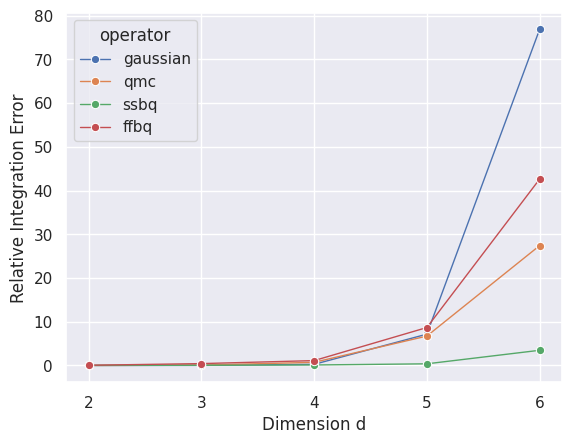

In [11]:
sns.set_theme()
fig = sns.lineplot(
    best_each_d, x="d", y="bqrel_mean", hue="operator", 
    linewidth=1, estimator="lowess", marker="o"
)
# fig.set(yscale="log")

# for operator, color in zip(best_each_d['operator'].unique(), sns.color_palette()):
#     subset = best_each_d[best_each_d['operator'] == operator]
#     plt.errorbar(x=subset['d'], y=subset['bqrel_mean'], yerr=subset['bqrel_std'], fmt='o', color=color, capsize=5)

plt.xlabel("Dimension d")
plt.ylabel("Relative Integration Error")

plt.show()

In [12]:
# best across d as a plurality
best_over_d = best_operator_plurality(d_sum, best_each_d)
best_over_d

,gptype,ktype,operator,sol,d,bqerr_mean,bqerr_std,bqrel_mean,bqrel_std,nll_mean,nll_std
0,gp,rbf,gaussian,-0.0162558408042687,2,0.000028,0.000014,0.001739,0.000844,-3498.363770,0.512996
1,gp,fin,qmc,-0.0162558408042687,2,0.000036,0.000013,0.002235,0.000810,-3223.431152,1.276672
2,lr,rff,ssbq,-0.0162558408042687,2,0.000103,0.000091,0.006361,0.005579,-1036.553601,4.285121
3,gp,fin,ffbq,-0.0162558408042687,2,0.000684,0.000398,0.042087,0.024469,-3223.431152,1.276672
4,gp,rbf,gaussian,-0.004755372084347909,3,0.000073,0.000054,0.015415,0.011288,-2944.395898,4.037566
5,lr,rff,ssbq,-0.004755372084347909,3,0.000226,0.000103,0.047533,0.021711,-998.263971,4.618012
6,gp,fin,qmc,-0.004755372084347909,3,0.000246,0.000191,0.051675,0.040223,-1997.769067,11.893854
7,gp,fin,ffbq,-0.004755372084347909,3,0.000857,0.000618,0.180203,0.130001,-1997.769067,11.893854
8,lr,rff,ssbq,0.0027555905687096666,4,0.000305,0.000387,0.110863,0.140520,-968.927826,8.536944
9,gp,rbf,gaussian,0.0027555905687096666,4,0.000709,0.000470,0.257132,0.170603,-1353.088086,10.470819


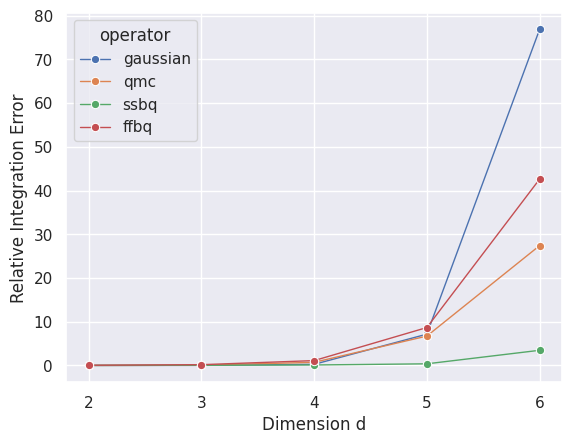

In [13]:
sns.set_theme()
fig = sns.lineplot(
    best_over_d, x="d", y="bqrel_mean", hue="operator", 
    linewidth=1, estimator="lowess", marker="o"
)
# fig.set(yscale="log")

# for operator, color in zip(best_each_d['operator'].unique(), sns.color_palette()):
#     subset = best_each_d[best_each_d['operator'] == operator]
#     plt.errorbar(x=subset['d'], y=subset['bqrel_mean'], yerr=subset['bqrel_std'], fmt='o', color=color, capsize=5)

plt.xlabel("Dimension d")
plt.ylabel("Relative Integration Error")

plt.show()

In [14]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_qmc_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="mc", s=5)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_fft_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

## Tables

In [16]:
paper_tab = best_over_d[["operator", "ktype", "d", "bqerr_mean", "bqerr_std"]]
paper_tab = paper_tab[paper_tab["d"].isin(['2', '4', '6'])]
paper_tab["model"] = paper_tab["operator"] + " " + paper_tab["ktype"]
paper_tab = paper_tab.drop(columns=["operator", "ktype"])
paper_tab_mean = paper_tab.pivot(index="model", columns="d", values="bqerr_mean").reset_index()
paper_tab_std = paper_tab.pivot(index="model", columns="d", values="bqerr_std").reset_index()
joint_df = paper_tab_mean.copy()

In [17]:
joint_df

d,model,2,4,6
0,ffbq fin,0.000684,0.003059,0.006090
1,gaussian rbf,0.000028,0.000709,0.010983
2,qmc fin,0.000036,0.001978,0.003916
3,ssbq rff,0.000103,0.000305,0.000496


In [19]:
for col in ["2", "4", "6"]:
    joint_df[col] = joint_df[col].map("{:.2e}".format) + " ± " + paper_tab_std[col].map("{:.2e}".format)

In [20]:
print(joint_df.iloc[[1, 2, 0, 3]].to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model & 2 & 4 & 6 \\
\midrule
gaussian rbf & 2.83e-05 ± 1.37e-05 & 7.09e-04 ± 4.70e-04 & 1.10e-02 ± 9.39e-03 \\
qmc fin & 3.63e-05 ± 1.32e-05 & 1.98e-03 ± 1.15e-03 & 3.92e-03 ± 4.12e-03 \\
ffbq fin & 6.84e-04 ± 3.98e-04 & 3.06e-03 ± 1.96e-03 & 6.09e-03 ± 6.11e-03 \\
ssbq rff & 1.03e-04 ± 9.07e-05 & 3.05e-04 ± 3.87e-04 & 4.96e-04 ± 3.42e-04 \\
\bottomrule
\end{tabular}

